In [1]:
# import os
# os.listdir('../input')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob, re
pd.set_option('display.max_columns',10000); pd.set_option('display.max_rows', 50); np.set_printoptions(threshold=90000)

In [2]:
path='../../input/'
# a = pd.read_csv(f'{path}air_reserve.csv',)
asi = pd.read_csv(f'{path}air_store_info.csv',)
avd = pd.read_csv(f'{path}air_visit_data.csv',)
di = pd.read_csv(f'{path}date_info.csv',)
# a = pd.read_csv(f'{path}hpg_reserve.csv',)
# a = pd.read_csv(f'{path}hpg_store_info.csv',)
sa = pd.read_csv(f'{path}sample_submission.csv',)
# a = pd.read_csv(f'{path}store_id_relation.csv',)


In [3]:
'''
- 店ごとに日付ごとの平均を出すと同時にnanを作って0で補完

'''
avd.index = pd.to_datetime(avd['visit_date'])
# # 店ごとに特定の日に何人来たか
avd = avd.groupby('air_store_id').apply(lambda g: g['visitors'].resample('1d').mean()).reset_index()
# avd.query("air_store_id == 'air_00a91d42b08b08d9'" and "visit_date > '2016-07-01'" )
# filtered_df=df.query("Joined_date >= '2019-06-1' and Joined_date <='2020-02-05'")
avd['visit_date'] = avd['visit_date'].dt.strftime('%Y-%m-%d')
avd['was_nil'] = avd['visitors'].isnull()
avd['visitors'].fillna(0, inplace=True)

avd.head(1)
# avd.shape

,air_store_id,visit_date,visitors,was_nil
0,air_00a91d42b08b08d9,2016-07-01,35.0,False


In [4]:
# ラグ特徴量作成
date_info = pd.read_csv(f'{path}/date_info.csv')
date_info.rename(columns={'calendar_date': 'visit_date','holiday_flg': 'is_holiday'}, inplace=True)
date_info['prev_day_is_holiday'] = date_info['is_holiday'].shift().fillna(0)
date_info['next_day_is_holiday'] = date_info['is_holiday'].shift(-1).fillna(0)

date_info.head(1)
# date_info.shift()

,visit_date,day_of_week,is_holiday,prev_day_is_holiday,next_day_is_holiday
0,2016-01-01,Friday,1,0.0,1.0


In [5]:
'''
外れ値を適正値の中の最大値に置換
'''
def find_outliers(series):
    # 条件式なのでTrue,falseが返る
    return (series - series.mean()) > 2.4 * series.std()

def cap_values(series):
    outliers = find_outliers(series)
    max_val = series[~outliers].max()
    series[outliers] = max_val
    return series


stores = avd.groupby('air_store_id')
stores.apply(lambda g: find_outliers(g['visitors'])).values
avd['is_outlier'] = stores.apply(lambda g: find_outliers(g['visitors'])).values

avd['visitors_capped'] = stores.apply(lambda g: cap_values(g['visitors'])).values
avd['visitors_capped_log1p'] = np.log1p(avd['visitors_capped'])

# avd.query("visit_date > '2016-01-01'" and "visit_date < '2016-01-05'").head(20)

In [6]:
sa['air_store_id'] = sa['id'].str.slice(0, 20)
sa['visit_date'] = sa['id'].str.slice(21)
sa['is_test'] = True
sa['visitors'] = np.nan
sa['test_number'] = range(len(sa))
# sa

In [7]:
'''air_visit+sample_submission+date_info+air_store_info'''

data = pd.concat((avd, sa.drop('id', axis='columns')))
data['is_test'].fillna(False, inplace=True)
data = pd.merge(data, date_info, how='left', left_on=['visit_date'], right_on=['visit_date'])
data = pd.merge(left=data, right=asi, on='air_store_id', how='left')


In [8]:
data['visit_date'] = pd.to_datetime(data['visit_date'])
data.index = data['visit_date']

# astypeでtrue,false→1,0に変換できる
data['is_weekend'] = data['day_of_week'].isin(['Saturday', 'Sunday']).astype(int)
data['day_of_month'] = data['visit_date'].dt.day
data = pd.get_dummies(data, columns=['day_of_week', 'air_genre_name'])

In [9]:
'''
air_store_id
visit_date
test_number

is_holiday
prev_day_is_holiday
next_day_is_holiday

air_area_name

latitude
longitude

is_weekend
day_of_month
day_of_week_??
air_genre_name_??

識別フラグ
is_test
was_nil

visitors
is_outlier
visitors_capped
visitors_capped_log1p
'''
data.head(2)

,air_store_id,visit_date,visitors,was_nil,is_outlier,visitors_capped,visitors_capped_log1p,is_test,test_number,is_holiday,prev_day_is_holiday,next_day_is_holiday,air_area_name,latitude,longitude,is_weekend,day_of_month,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,air_genre_name_Asian,air_genre_name_Bar/Cocktail,air_genre_name_Cafe/Sweets,air_genre_name_Creative cuisine,air_genre_name_Dining bar,air_genre_name_International cuisine,air_genre_name_Italian/French,air_genre_name_Izakaya,air_genre_name_Japanese food,air_genre_name_Karaoke/Party,air_genre_name_Okonomiyaki/Monja/Teppanyaki,air_genre_name_Other,air_genre_name_Western food,air_genre_name_Yakiniku/Korean food
visit_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-07-01,air_00a91d42b08b08d9,2016-07-01,35.0,False,False,35.0,3.583519,False,NaN,0,0.0,0.0,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2016-07-02,air_00a91d42b08b08d9,2016-07-02,9.0,False,False,9.0,2.302585,False,NaN,0,0.0,0.0,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,1,2,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [10]:
# data['visitors_log1p'] = np.log1p(data['visitors'])
train = data[(data['is_test'] == False) & (data['is_outlier'] == False) & (data['was_nil'] == False)]
test = data[data['is_test']].sort_values('test_number')

to_drop = ['air_store_id', 'is_test', 'test_number', 'visit_date', 'was_nil',
           'is_outlier', 'visitors_capped', 'visitors', 'air_area_name']
        #    'visitors_capped_log1p']
# to_drop = ['air_store_id', 'is_test', 'test_number', 'visit_date', 'was_nil',
#            'is_outlier', 'visitors_capped', 'visitors', 'air_area_name',
#            'station_id', 'station_latitude', 'station_longitude', 'station_vincenty',
#            'station_great_circle', 'visitors_capped_log1p']
train = train.drop(to_drop, axis='columns')
train = train.dropna()
test = test.drop(to_drop, axis='columns')

# X_train = train.drop('visitors_log1p', axis='columns')
X_train = train.drop('visitors_capped_log1p', axis='columns')
X_test = test.drop('visitors_capped_log1p', axis='columns')
# X_test = test.drop('visitors_log1p', axis='columns')
# y_train = train['visitors_log1p']
y_train = train['visitors_capped_log1p']

In [16]:
X_train.shape

(247224, 28)

In [15]:
'''メモ
検証でほしいデータ

バリデーションスコアの平均、標準偏差
バリデーションごとの変数重要度
dataframeに入れれば扱いやすい
'''
import lightgbm as lgbm
from sklearn import metrics
from sklearn import model_selection

np.random.seed(0)

model = lgbm.LGBMRegressor(
    objective='regression',
    max_depth=5,
    num_leaves=5 ** 2 - 1,
    learning_rate=0.007,
    n_estimators=30000,
    min_child_samples=80,
    subsample=0.8,
    colsample_bytree=1,
    reg_alpha=0,
    reg_lambda=0,
    random_state=np.random.randint(10e6)
)

n_splits = 6
cv = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=0)

val_scores = [0] * n_splits

sub = sa['id'].to_frame()
sub['visitors'] = 0

feature_importances = pd.DataFrame(index=X_train.columns)

for i, (fit_idx, val_idx) in enumerate(cv.split(X_train, y_train)):
    
    X_fit = X_train.iloc[fit_idx]
    y_fit = y_train.iloc[fit_idx]
    X_val = X_train.iloc[val_idx]
    y_val = y_train.iloc[val_idx]
    
    model.fit(
        X_fit,
        y_fit,
        eval_set=[(X_fit, y_fit), (X_val, y_val)],
        eval_names=('fit', 'val'),
        eval_metric='l2',
        early_stopping_rounds=200,
        feature_name=X_fit.columns.tolist(),
        verbose=True
    )
    
    val_scores[i] = np.sqrt(model.best_score_['val']['l2'])
    sub['visitors'] += model.predict(X_test, num_iteration=model.best_iteration_)
    feature_importances[i] = model.feature_importances_
    
    print('Fold {} RMSLE: {:.5f}'.format(i+1, val_scores[i]))
    
sub['visitors'] /= n_splits
sub['visitors'] = np.expm1(sub['visitors'])

val_mean = np.mean(val_scores)
val_std = np.std(val_scores)

print('Local RMSLE: {:.5f} (±{:.5f})'.format(val_mean, val_std))

C:\Users\thyt\tfgpu2\.venv\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\thyt\tfgpu2\.venv\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	fit's l2: 0.634457	val's l2: 0.639751
[2]	fit's l2: 0.633617	val's l2: 0.638891
[3]	fit's l2: 0.632783	val's l2: 0.638036
[4]	fit's l2: 0.631966	val's l2: 0.6372
[5]	fit's l2: 0.63116	val's l2: 0.636381
[6]	fit's l2: 0.630366	val's l2: 0.635568
[7]	fit's l2: 0.629583	val's l2: 0.634772
[8]	fit's l2: 0.62881	val's l2: 0.633981
[9]	fit's l2: 0.628048	val's l2: 0.633205
[10]	fit's l2: 0.627288	val's l2: 0.632425
[11]	fit's l2: 0.62654	val's l2: 0.631657
[12]	fit's l2: 0.625807	val's l2: 0.630914
[13]	fit's l2: 0.625078	val's l2: 0.630164
[14]	fit's l2: 0.624364	val's l2: 0.629437
[15]	fit's l2: 0.623649	val's l2: 0.628708
[16]	fit's l2: 0.622948	val's l2: 0.627988
[17]	fit's l2: 0.622262	val's l2: 0.627291
[18]	fit's l2: 0.621568	val's l2: 0.626585
[19]	fit's l2: 0.620891	val's l2: 0.625893
[20]	fit's l2: 0.620215	val's l2: 0.625205
[21]	fit's l2: 0.619556	val's l2: 0.624531
[22]	fit's l2: 0.618899	val's l2: 0.623862
[23]	fit's l2: 0.618257	val's l2: 0.623206
[24]	fit's l2: 0.617623	v

KeyboardInterrupt: 

In [ ]:
feature_importances.sort_values(0, ascending=False)

In [ ]:
model.feature_importances_

In [ ]:
model.best_score_

In [41]:
import datetime
def mk_now():
    # JSTとUTCの差分
    DIFF_JST_FROM_UTC = 9
    NOW = (datetime.datetime.utcnow() + datetime.timedelta(hours=DIFF_JST_FROM_UTC)).strftime('%Y-%m-%d_%H-%M-%S')
    NOW = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    return NOW
NOW = mk_now()
NOW

'2021-08-14_17-31-27'

In [53]:
%pwd

'c:\\Users\\hayatotominaga\\Kaggle\\N-Recruit_Restaurant\\notebooks\\m'

In [55]:
# missing_values_table(sub)
sub.to_csv(f'../../output/{NOW}.csv',index=False)
tmp = pd.read_csv(f'../../output/{NOW}.csv')
tmp

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,17.291871
1,air_00a91d42b08b08d9_2017-04-24,16.572818
2,air_00a91d42b08b08d9_2017-04-25,19.800194
3,air_00a91d42b08b08d9_2017-04-26,22.718256
4,air_00a91d42b08b08d9_2017-04-27,23.086335
...,...,...
32014,air_fff68b929994bfbd_2017-05-27,11.089224
32015,air_fff68b929994bfbd_2017-05-28,9.216507
32016,air_fff68b929994bfbd_2017-05-29,5.777259
32017,air_fff68b929994bfbd_2017-05-30,6.802609


In [ ]:
s = pd.read_csv(f'{path}sample_submission.csv',)

s['store_id'] = s['id'].str[:20]; s['visit_date'] = s['id'].str[21:]

s.drop(['visitors'], axis=1, inplace=True)

s['visit_date'] = pd.to_datetime(s['visit_date'])
# 念のためカラム情報の確認
s.info();s.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32019 entries, 0 to 32018
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          32019 non-null  object        
 1   store_id    32019 non-null  object        
 2   visit_date  32019 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(2)
memory usage: 750.6+ KB


,id,store_id,visit_date
0,air_00a91d42b08b08d9_2017-04-23,air_00a91d42b08b08d9,2017-04-23
1,air_00a91d42b08b08d9_2017-04-24,air_00a91d42b08b08d9,2017-04-24
2,air_00a91d42b08b08d9_2017-04-25,air_00a91d42b08b08d9,2017-04-25
3,air_00a91d42b08b08d9_2017-04-26,air_00a91d42b08b08d9,2017-04-26
4,air_00a91d42b08b08d9_2017-04-27,air_00a91d42b08b08d9,2017-04-27


In [ ]:
aggregation = {'visitors' : 'median'}
vagg = v.groupby(['air_store_id','dow']).agg(aggregation).reset_index()
vagg

,air_store_id,dow,visitors
0,air_00a91d42b08b08d9,0,19.0
1,air_00a91d42b08b08d9,1,24.5
2,air_00a91d42b08b08d9,2,28.0
3,air_00a91d42b08b08d9,3,30.0
4,air_00a91d42b08b08d9,4,35.5
...,...,...,...
5736,air_fff68b929994bfbd,2,4.0
5737,air_fff68b929994bfbd,3,4.0
5738,air_fff68b929994bfbd,4,5.0
5739,air_fff68b929994bfbd,5,7.0


In [ ]:
merged = pd.merge(s, vagg, how='left', left_on=['store_id', 'dow'], right_on=['air_store_id', 'dow'])
 
# idとvisitorsだけをsubmitへ格納
submit = merged[['id', 'visitors']]
 
# submitのヘッダー情報
missing_values_table(submit)

Your selected dataframe has 2 columns.
There are 1 columns that have missing values.


,Missing Values,% of Total Values
visitors,341,1.1


In [163]:
# submit.fillna(0, inplace=True)
# 念のため確認
missing_values_table(sub)

Your selected dataframe has 2 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [161]:
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns


重み付き平均（加重平均）を算出  
「曜日」と「祝日フラグ」  
前処理  
- 週末の場合（土曜日or日曜日）は、祝日であってもフラグを0とする処理を行いましょう。
- 日付を基に「重み」を作成
    - 日付が古いものには少ない重みを、予測する日付に近い（新しい日付）には多い重み
- air_visit_data(Airレジの各レストランの実客数データ）に上記で算出したWeight（重み）を加えて、visitors（実客数）をnp.log1pを使って対数にして、「air_store_id」「day_of_week」「holiday_flg」（各レストランID、曜日、祝日フラグ）でグルーピングをして 重み付き平均を算出します。

In [ ]:
# axis{0 or ‘index’, 1 or ‘columns’}, default 0
# 0 or ‘index’: apply function to each column.
weekend_hdays = di.apply((lambda x:(x.day_of_week=='Sunday' or x.day_of_week=='Saturday') and x.holiday_flg==1), axis=1)
weekend_hdays
# # date_infoの該当の箇所のフラグを1から0へ更新をする
di.loc[weekend_hdays, 'holiday_flg'] = 0
 
 

In [ ]:
di['weight'] = (di.index + 1) / len(di) 

,calendar_date,day_of_week,holiday_flg,weight
512,2017-05-27,Saturday,0,0.992263
513,2017-05-28,Sunday,0,0.994197
514,2017-05-29,Monday,0,0.996132
515,2017-05-30,Tuesday,0,0.998066
516,2017-05-31,Wednesday,0,1.000000


In [ ]:
v

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6
...,...,...,...
252103,air_24e8414b9b07decb,2017-04-18,6
252104,air_24e8414b9b07decb,2017-04-19,6
252105,air_24e8414b9b07decb,2017-04-20,7
252106,air_24e8414b9b07decb,2017-04-21,8


In [ ]:
vd = v.merge(di, left_on='visit_date', right_on='calendar_date', how='left')
vd.drop('calendar_date', axis=1, inplace=True)
 
# vdの実客数にnp.log1pの対数関数を使って処理
vd['visitors'] = vd.visitors.map(np.log1p)
 
# vdの確認
vd.head(10)
 

,air_store_id,visit_date,visitors,day_of_week,holiday_flg,weight
0,air_ba937bf13d40fb24,2016-01-13,3.258097,Wednesday,0,0.025145
1,air_ba937bf13d40fb24,2016-01-14,3.496508,Thursday,0,0.027079
2,air_ba937bf13d40fb24,2016-01-15,3.401197,Friday,0,0.029014
3,air_ba937bf13d40fb24,2016-01-16,3.135494,Saturday,0,0.030948
4,air_ba937bf13d40fb24,2016-01-18,1.945910,Monday,0,0.034816
5,air_ba937bf13d40fb24,2016-01-19,2.302585,Tuesday,0,0.036750
6,air_ba937bf13d40fb24,2016-01-20,3.465736,Wednesday,0,0.038685
7,air_ba937bf13d40fb24,2016-01-21,3.091042,Thursday,0,0.040619
8,air_ba937bf13d40fb24,2016-01-22,2.944439,Friday,0,0.042553
9,air_ba937bf13d40fb24,2016-01-23,3.295837,Saturday,0,0.044487


In [ ]:
wmean = lambda x:( (x.weight * x.visitors).sum() / x.weight.sum() )
 
 
# グルーピングして重み付き平均を算出
visitors = vd.groupby(
    ['air_store_id', 'day_of_week', 'holiday_flg']).apply(wmean).reset_index()
visitors.rename(columns={0:'visitors'}, inplace=True) 
 
# データを確認
visitors.head(10)

,air_store_id,day_of_week,holiday_flg,visitors
0,air_00a91d42b08b08d9,Friday,0,3.590026
1,air_00a91d42b08b08d9,Monday,0,3.091672
2,air_00a91d42b08b08d9,Monday,1,3.091042
3,air_00a91d42b08b08d9,Saturday,0,2.526836
4,air_00a91d42b08b08d9,Sunday,0,1.098612
5,air_00a91d42b08b08d9,Thursday,0,3.414904
6,air_00a91d42b08b08d9,Tuesday,0,3.173611
7,air_00a91d42b08b08d9,Wednesday,0,3.330028
8,air_0164b9927d20bcc3,Friday,0,2.327400
9,air_0164b9927d20bcc3,Friday,1,2.747824


In [ ]:
s

,id,store_id,visit_date,dow,air_store_id,calendar_date
0,air_00a91d42b08b08d9_2017-04-23,air_00a91d42b08b08d9,2017-04-23,6,air_00a91d42b08b08d9,2017-04-23
1,air_00a91d42b08b08d9_2017-04-24,air_00a91d42b08b08d9,2017-04-24,0,air_00a91d42b08b08d9,2017-04-24
2,air_00a91d42b08b08d9_2017-04-25,air_00a91d42b08b08d9,2017-04-25,1,air_00a91d42b08b08d9,2017-04-25
3,air_00a91d42b08b08d9_2017-04-26,air_00a91d42b08b08d9,2017-04-26,2,air_00a91d42b08b08d9,2017-04-26
4,air_00a91d42b08b08d9_2017-04-27,air_00a91d42b08b08d9,2017-04-27,3,air_00a91d42b08b08d9,2017-04-27
...,...,...,...,...,...,...
32014,air_fff68b929994bfbd_2017-05-27,air_fff68b929994bfbd,2017-05-27,5,air_fff68b929994bfbd,2017-05-27
32015,air_fff68b929994bfbd_2017-05-28,air_fff68b929994bfbd,2017-05-28,6,air_fff68b929994bfbd,2017-05-28
32016,air_fff68b929994bfbd_2017-05-29,air_fff68b929994bfbd,2017-05-29,0,air_fff68b929994bfbd,2017-05-29
32017,air_fff68b929994bfbd_2017-05-30,air_fff68b929994bfbd,2017-05-30,1,air_fff68b929994bfbd,2017-05-30


In [ ]:
ss = pd.read_csv(f'{path}sample_submission.csv',)

ss['store_id'] = ss['id'].str[:20]; ss['visit_date'] = ss['id'].str[21:]
# ss.drop(['visitors'], axis=1, inplace=True)

ss['visit_date'] = pd.to_datetime(ss['visit_date'])


In [ ]:
ss

,id,visitors,store_id,visit_date
0,air_00a91d42b08b08d9_2017-04-23,0,air_00a91d42b08b08d9,2017-04-23
1,air_00a91d42b08b08d9_2017-04-24,0,air_00a91d42b08b08d9,2017-04-24
2,air_00a91d42b08b08d9_2017-04-25,0,air_00a91d42b08b08d9,2017-04-25
3,air_00a91d42b08b08d9_2017-04-26,0,air_00a91d42b08b08d9,2017-04-26
4,air_00a91d42b08b08d9_2017-04-27,0,air_00a91d42b08b08d9,2017-04-27
...,...,...,...,...
32014,air_fff68b929994bfbd_2017-05-27,0,air_fff68b929994bfbd,2017-05-27
32015,air_fff68b929994bfbd_2017-05-28,0,air_fff68b929994bfbd,2017-05-28
32016,air_fff68b929994bfbd_2017-05-29,0,air_fff68b929994bfbd,2017-05-29
32017,air_fff68b929994bfbd_2017-05-30,0,air_fff68b929994bfbd,2017-05-30


In [ ]:

ss['air_store_id'] = ss.id.map(
    lambda x: '_'.join(x.split('_')[:-1]))
ss

,id,visitors,store_id,visit_date,air_store_id
0,air_00a91d42b08b08d9_2017-04-23,0,air_00a91d42b08b08d9,2017-04-23,air_00a91d42b08b08d9
1,air_00a91d42b08b08d9_2017-04-24,0,air_00a91d42b08b08d9,2017-04-24,air_00a91d42b08b08d9
2,air_00a91d42b08b08d9_2017-04-25,0,air_00a91d42b08b08d9,2017-04-25,air_00a91d42b08b08d9
3,air_00a91d42b08b08d9_2017-04-26,0,air_00a91d42b08b08d9,2017-04-26,air_00a91d42b08b08d9
4,air_00a91d42b08b08d9_2017-04-27,0,air_00a91d42b08b08d9,2017-04-27,air_00a91d42b08b08d9
...,...,...,...,...,...
32014,air_fff68b929994bfbd_2017-05-27,0,air_fff68b929994bfbd,2017-05-27,air_fff68b929994bfbd
32015,air_fff68b929994bfbd_2017-05-28,0,air_fff68b929994bfbd,2017-05-28,air_fff68b929994bfbd
32016,air_fff68b929994bfbd_2017-05-29,0,air_fff68b929994bfbd,2017-05-29,air_fff68b929994bfbd
32017,air_fff68b929994bfbd_2017-05-30,0,air_fff68b929994bfbd,2017-05-30,air_fff68b929994bfbd


In [ ]:

ss['calendar_date'] = ss.id.map(lambda x: x.split('_')[2])
 
# 重み付き平均で予測したvisitorsとsをマージする
ss.drop('visitors', axis=1, inplace=True)
ss = ss.merge(di, on='calendar_date', how='left')
ss = ss.merge(
    visitors, on=['air_store_id', 'day_of_week', 'holiday_flg'], how='left')
 
# データセットを確認してみよう
ss.head()

,id,store_id,visit_date,air_store_id,calendar_date,day_of_week,holiday_flg,weight,visitors
0,air_00a91d42b08b08d9_2017-04-23,air_00a91d42b08b08d9,2017-04-23,air_00a91d42b08b08d9,2017-04-23,Sunday,0,0.926499,1.098612
1,air_00a91d42b08b08d9_2017-04-24,air_00a91d42b08b08d9,2017-04-24,air_00a91d42b08b08d9,2017-04-24,Monday,0,0.928433,3.091672
2,air_00a91d42b08b08d9_2017-04-25,air_00a91d42b08b08d9,2017-04-25,air_00a91d42b08b08d9,2017-04-25,Tuesday,0,0.930368,3.173611
3,air_00a91d42b08b08d9_2017-04-26,air_00a91d42b08b08d9,2017-04-26,air_00a91d42b08b08d9,2017-04-26,Wednesday,0,0.932302,3.330028
4,air_00a91d42b08b08d9_2017-04-27,air_00a91d42b08b08d9,2017-04-27,air_00a91d42b08b08d9,2017-04-27,Thursday,0,0.934236,3.414904


In [ ]:
missing_values_table(ss)

Your selected dataframe has 9 columns.
There are 1 columns that have missing values.


,Missing Values,% of Total Values
visitors,668,2.1


In [ ]:
missings = ss.visitors.isnull()
ss.loc[missings, 'visitors'] = ss[missings].merge(
    visitors[visitors.holiday_flg==0], on=(
        'air_store_id', 'day_of_week'), how='left')['visitors_y'].values
 
# 改めて欠損データの確認
missing_values_table(ss)

Your selected dataframe has 9 columns.
There are 1 columns that have missing values.


,Missing Values,% of Total Values
visitors,448,1.4


In [ ]:
missings = ss.visitors.isnull()
ss.loc[missings, 'visitors'] = ss[missings].merge(
    visitors[['air_store_id', 'visitors']].groupby('air_store_id').mean().reset_index(), 
    on='air_store_id', how='left')['visitors_y'].values
 
# 欠損データを確認
missing_values_table(ss)

Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [ ]:
ss['visitors'] = ss.visitors.map(np.expm1)
 
# 提出フォーマットの規定に合うように処理してsub_fileへ格納
ss = ss[['id', 'visitors']]
ss['visitors'][ss['visitors'] ==0] = ss['visitors'][ss['visitors'] ==0]
sub_file = ss.copy()
 
# データの確認
sub_file.head()
 

C:\Users\hayatotominaga\anaconda3\envs\rake4\lib\site-packages\pandas\core\base.py:937: RuntimeWarning: overflow encountered in expm1
  new_values = map_f(values, mapper)
<ipython-input-222-9a15c4f3069f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ss['visitors'][ss['visitors'] ==0] = ss['visitors'][ss['visitors'] ==0]


,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,594.294415
1,air_00a91d42b08b08d9_2017-04-24,inf
2,air_00a91d42b08b08d9_2017-04-25,inf
3,air_00a91d42b08b08d9_2017-04-26,inf
4,air_00a91d42b08b08d9_2017-04-27,inf


In [ ]:
a = pd.read_csv(f'{path}hpg_reserve.csv',)


In [ ]:
a.dtypes

hpg_store_id        object
visit_datetime      object
reserve_datetime    object
reserve_visitors     int64
dtype: object

In [ ]:
a['date'] = pd.to_datetime(a.visit_datetime); a.set_index("date",inplace=True)

In [ ]:
a = a.sort_index();a
a

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors
date,,,,
2016-01-01 11:00:00,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1
2016-01-01 13:00:00,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3
2016-01-01 16:00:00,hpg_c8e24dcf51ca1eb5,2016-01-01 16:00:00,2016-01-01 14:00:00,2
2016-01-01 17:00:00,hpg_24bb207e5fd49d4a,2016-01-01 17:00:00,2016-01-01 11:00:00,5
2016-01-01 17:00:00,hpg_25291c542ebb3bc2,2016-01-01 17:00:00,2016-01-01 03:00:00,13
...,...,...,...,...
2017-05-31 20:00:00,hpg_2b293477ea4642fb,2017-05-31 20:00:00,2017-04-19 07:00:00,2
2017-05-31 20:00:00,hpg_f922aeca48ca5a29,2017-05-31 20:00:00,2017-03-19 00:00:00,3
2017-05-31 21:00:00,hpg_e9151de687b93aa3,2017-05-31 21:00:00,2017-04-14 20:00:00,49


In [ ]:
a.groupby(['hpg_store_id','visit_datetime']).agg(sum)

reserve_visitors
hpg_store_id         visit_datetime                       
hpg_001112ef76b9802c 2016-02-26 19:00:00                 9
                     2016-03-17 19:00:00                 3
                     2016-03-31 18:00:00                 5
                     2016-04-05 18:00:00                13
                     2016-04-18 17:00:00                 9
...                                                    ...
hpg_fffc097dce87af3e 2017-03-10 19:00:00                 2
                     2017-03-17 19:00:00                 2
                     2017-03-27 19:00:00                 5
                     2017-04-21 18:00:00                 3
                     2017-04-23 18:00:00                 8

[1711380 rows x 1 columns]

In [ ]:
a.reset_index(inplace=True)
a.sort_values('hpg_store_id')

,date,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors
731442,2016-09-07 18:00:00,hpg_001112ef76b9802c,2016-09-07 18:00:00,2016-08-22 10:00:00,5
1976775,2017-04-27 18:00:00,hpg_001112ef76b9802c,2017-04-27 18:00:00,2017-04-22 22:00:00,15
1969937,2017-04-24 19:00:00,hpg_001112ef76b9802c,2017-04-24 19:00:00,2017-04-19 04:00:00,1
830059,2016-10-06 19:00:00,hpg_001112ef76b9802c,2016-10-06 19:00:00,2016-10-02 19:00:00,22
1203285,2016-12-20 19:00:00,hpg_001112ef76b9802c,2016-12-20 19:00:00,2016-12-12 18:00:00,4
...,...,...,...,...,...
1810370,2017-03-27 19:00:00,hpg_fffc097dce87af3e,2017-03-27 19:00:00,2017-03-22 14:00:00,5
1946673,2017-04-21 18:00:00,hpg_fffc097dce87af3e,2017-04-21 18:00:00,2017-04-18 21:00:00,3
924278,2016-10-30 19:00:00,hpg_fffc097dce87af3e,2016-10-30 19:00:00,2016-10-20 20:00:00,13
698030,2016-08-26 19:00:00,hpg_fffc097dce87af3e,2016-08-26 19:00:00,2016-08-23 18:00:00,3


In [ ]:
a.pivot(index='visit_datetime', columns='hpg_store_id', values='reserve_visitors')

ValueError: Index contains duplicate entries, cannot reshape

# 検証コード

<AxesSubplot:ylabel='Frequency'>

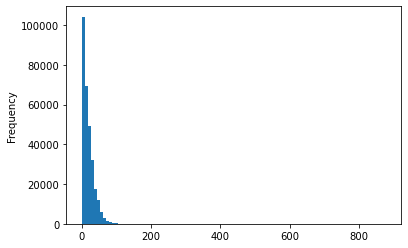

In [ ]:
# 売り上げが正規分布に従っているか検証、１店舗ごとにプロットすると正規分布に従うことがわかる
tmp = air_visit.query("air_store_id == 'air_00a91d42b08b08d9'")
# tmp['visitors'].plot.hist(bins=100)
# air_visit['visitors'].plot.hist(bins=100)

In [ ]:
cv.split(X_train, y_train)